Optuna Hyperparameter Tuning with 50 Trials on a random 10X10 Grid for the period 
Training : 1985-2015
Testing : 2016 - 2020
Variable of Interest: Tasmean

In [1]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta
from logging.config import dictConfig
import numpy as np
import datetime
import pathlib
import pandas as pd
import joblib
import plotly
import optuna
from sklearn.metrics import mean_squared_error
import math
import random

# externals
import xarray as xr

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# locals
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset

from downscaleml.main.config import (NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
                                     CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
                                     OVERWRITE, DEM, DEM_FEATURES, STRATIFY,
                                     WET_DAY_THRESHOLD, VALID_SIZE, 
                                     start_year, end_year, CHUNKS, combination)

from downscaleml.main.inputoutput import (ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH)

from downscaleml.core.constants import (ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
                                        ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
                                        ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
                                        PREDICTANDS, ERA5_P_VARIABLES, ERA5_S_VARIABLES)

from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf

from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score
    
# module level logger
LOGGER = logging.getLogger(__name__)

def stacker(xarray_dataset):
    # stack along the lat and lon dimensions
    stacked = xarray_dataset.stack()
    dask_arr = stacked.to_array().data
    xarray_dataset = dask_arr.T
    LogConfig.init_log('Shape of the numpy array is in (spatial, time, variables):{}'.format(xarray_dataset.shape))
    return xarray_dataset

def doy_encoding(X, y=None, doy=False):

    # whether to include the day of the year as predictor variable
    if doy:
        # add doy to set of predictor variables
        LOGGER.info('Adding day of the year to predictor variables ...')
        X = X.assign(EoDataset.encode_doys(X, chunks=X.chunks))

    print(X)
    return X

if __name__ == '__main__':

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    # check if target dataset already exists
    target = target.joinpath(state_file.name + '.nc')
    if target.exists() and not OVERWRITE:
        LogConfig.init_log('{} already exists.'.format(target))
        sys.exit()

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH.joinpath('ERA5'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})
    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])

    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
    Era5_valid = doy_encoding(Era5_valid, Obs_valid, doy=DOY)

    predictors_train = Era5_train
    predictors_valid = Era5_valid
    predictand_train = Obs_train
    predictand_valid = Obs_valid
    
    predictors_train = stacker(predictors_train).compute()
    predictors_valid = stacker(predictors_valid).compute()
    predictand_train = stacker(predictand_train)
    predictand_valid = stacker(predictand_valid)
    
    LogConfig.init_log('Dask computations done!')
    # iterate over the grid points
    LogConfig.init_log('Downscaling by Random Forest Starts: iterating each grid cell over time dimension')
    
    Models = {
        'RandomForestRegressor' : RandomForestRegressor,
        'XGBRegressor' : XGBRegressor,
        'AdaBoostRegressor': AdaBoostRegressor,
        'LGBMRegressor': LGBMRegressor,
    }
    Model_name = NET

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T17:57:08: Initializing downscaling for period: 1985-01-01 - 2015-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T17:57:08: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/p_REANALYSIS/ERA5/geo

<xarray.Dataset>
Dimensions:    (time: 11322, x: 161, y: 96)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2015-12-31
  * x          (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y          (y) float64 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables: (12/17)
    z_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    z_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    t_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    t_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    u_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    u_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    ...         ...
    t2m        (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    elevation  (time, 

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T17:57:22: Shape of the numpy array is in (spatial, time, variables):(161, 96, 11322, 17)
downscaleml.core.utils: --------------------------------------------------------------------------------


<xarray.Dataset>
Dimensions:    (time: 1826, x: 161, y: 96)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * x          (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y          (y) float64 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables: (12/17)
    z_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    z_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    t_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    t_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    u_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    u_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    ...         ...
    t2m        (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    elevation  (time, y

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T18:00:22: Shape of the numpy array is in (spatial, time, variables):(161, 96, 1826, 17)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T18:00:57: Shape of the numpy array is in (spatial, time, variables):(161, 96, 11322, 1)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T18:00:58: Shape of the numpy array is in (spatial, time, variables):(161, 96, 1826, 1)
downscaleml.core.utils: --------------------------------------------------------------------------------
do

CV Steps - 5 KFold cross validation

In [2]:

random.seed(42)

def grid_creator(combinations, numpy_object):
    gridded = np.ones(shape=(int(math.sqrt(combinations)), int(math.sqrt(combinations)), numpy_object.shape[2], numpy_object.shape[3])) * np.nan
    return gridded


predictors_train_grid = grid_creator(combination, predictors_train)
predictand_train_grid = grid_creator(combination, predictand_train)
predictors_valid_grid = grid_creator(combination, predictors_valid)
predictand_valid_grid = grid_creator(combination, predictand_valid)

x_range = (0, (predictand_train.shape[0] - 1))
y_range = (0, (predictand_train.shape[1] - 1))

x_numpy = np.ones(shape=(int(math.sqrt(combination))))
y_numpy = np.ones(shape=(int(math.sqrt(combination))))

for i in range(int(math.sqrt(combination))):
    x = random.randint(*x_range)
    y = random.randint(*y_range)
    x_numpy[i] = int(x)
    y_numpy[i] = int(y)

x = x_numpy.astype(int)
y = y_numpy.astype(int)

for i in range(int(math.sqrt(combination))):
    for j in range(int(math.sqrt(combination))):
        predictors_train_grid[i][j] = predictors_train[x[i], y[j], :, :]
        predictand_train_grid[i][j] = predictand_train[x[i], y[j], :, :]
        predictors_valid_grid[i][j] = predictors_valid[x[i], y[j], :, :] 
        predictand_valid_grid[i][j] = predictand_valid[x[i], y[j], :, :]

In [3]:
predictand_valid.shape

(161, 96, 1826, 1)

In [4]:
x.shape

(10,)

In [5]:
a = []
b = []
for i in range(int(math.sqrt(combination))):
    
    print(x[i], y[i])
    a.append(x[i])
    b.append(y[i])

28 3
70 31
57 17
26 86
139 11
151 54
8 3
23 27
59 64
154 3


In [6]:
a

[28, 70, 57, 26, 139, 151, 8, 23, 59, 154]

In [7]:
b

[3, 31, 17, 86, 11, 54, 3, 27, 64, 3]

In [8]:
lon, lat = np.squeeze(Obs_valid.x.values), np.squeeze(Obs_valid.y.values)

In [9]:
grid_x, grid_y = lon[a], lat[b]

In [10]:
reduced_grid_x = xr.DataArray(grid_x, dims=('x'))
reduced_grid_y = xr.DataArray(grid_y, dims=('y'))

Single Model - Iterating over all the grids

-
prediction = np.ones(shape=(predictand_valid_grid.shape[2], predictand_valid_grid.shape[1], predictand_valid_grid.shape[0])) * np.nan
model = Models[Model_name]()
r2_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mae_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))

for i in range(predictors_train_grid.shape[0]):
    for j in range(predictors_train_grid.shape[1]):

        point_predictors = predictors_train_grid[i, j, :, :]
        point_predictand = predictand_train_grid[i, j, :, :]

        # check if the grid point is valid
        if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
            # move on to next grid point
            continue

        # prepare predictors of validation period
        point_validation = predictors_valid_grid[i, j, :, :]
        #point_validation = normalize(point_validation)

        predictand_validation = predictand_valid_grid[i, j, :, :]

        LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))    
        # normalize each predictor variable to [0, 1]
        # point_predictors = normalize(point_predictors)
        # instanciate the model for the current grid point

        # train model on training data
        model.fit(point_predictors, point_predictand)
        # predict validation period
        pred = model.predict(point_validation)
        
        LogConfig.init_log('Processing grid point: {:d}, {:d} - score: {:.2f}'.format(i, j, r2_score(predictand_validation, pred)))
        r2_values[i][j] = r2_score(predictand_validation, pred)
        LogConfig.init_log('Processing grid point: {:d}, {:d} - score: {:.2f}'.format(i, j, mean_absolute_error(predictand_validation, pred)))
        mae_values[i][j] = mean_absolute_error(predictand_validation, pred)
        # store predictions for current grid point
        prediction[:, j, i] = pred


model.get_params()

np.mean(mae_values)

Using Optuna for Hyperparameter Optimising

In [11]:
predictand_train_grid.shape, predictors_train_grid.shape

((10, 10, 11322, 1), (10, 10, 11322, 17))

In [12]:


predictors_train_grid = predictors_train_grid.transpose(2, 1, 0, 3)
predictand_train_grid = predictand_train_grid.transpose(2, 1, 0, 3)
predictors_valid_grid = predictors_valid_grid.transpose(2, 1, 0, 3)
predictand_valid_grid = predictand_valid_grid.transpose(2, 1, 0, 3)
train_x, test_x, train_y, test_y = train_test_split(predictors_train_grid, predictand_train_grid, test_size=0.2,random_state=42)


In [13]:
np.squeeze(predictand_valid_grid).shape

(1826, 10, 10)

In [14]:

def objective(trial,data=predictors_train_grid,target=predictand_train_grid):

    #General parameters that would fit in any data
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'verbose' : -1,
        'early_stopping' : 100
    }

    model = LGBMRegressor(**param)
    rmse_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
    
    for i in range(train_x.shape[1]):
        for j in range(train_x.shape[2]):

            point_predictors = train_x[:, j, i, :]
            point_predictand = train_y[:, j, i, :]
    
            # check if the grid point is valid
            if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
                # move on to next grid point
                continue
    
            # prepare predictors of validation period
            point_validation = test_x[:, j, i, :]
            #point_validation = normalize(point_validation)

            predictand_validation = test_y[:, j, i, :]

            LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))    
            # normalize each predictor variable to [0, 1]
            # point_predictors = normalize(point_predictors)
            # instanciate the model for the current grid point
    
            # train model on training data
    
            model.fit(point_predictors,np.squeeze(point_predictand),eval_set=[(point_validation,predictand_validation)])
    
            preds = model.predict(point_validation)
            
            rmse = mean_squared_error(predictand_validation, preds,squared=False)
            rmse_values[i][j] = rmse
            mean_rmse = np.mean(rmse_values)
            
    return mean_rmse

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-02-18 18:00:58,823] A new study created in memory with name: no-name-f1ca4501-9d50-47e2-8d58-fb4513f83d96
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T18:00:59: Current grid point: (0), (0) 
downscaleml.core.utils: --------------------------------------------------------------------------------
/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T18:01:00: Current grid point: (0), (1) 
downscaleml.core.utils: --------------------------------------------------------------------------------
/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/lightgbm/basic.py:300: UserWarning: Converting col

In [16]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 50
Best trial: {'reg_alpha': 0.5538674094865402, 'reg_lambda': 5.885354785470161, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 65, 'min_child_samples': 1, 'min_data_per_groups': 35}


In [17]:
study.trials_dataframe().to_csv("output.csv", index=False) 


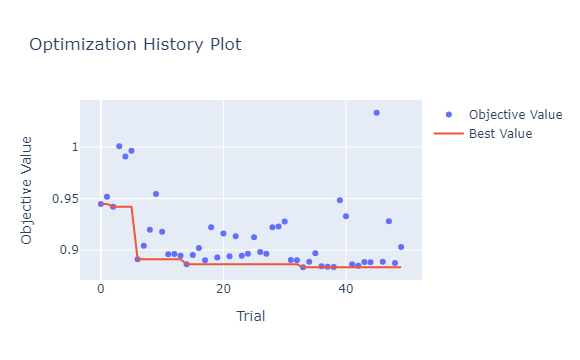

In [18]:
optuna.visualization.plot_optimization_history(study)


In [19]:
params=study.best_params   
params

{'reg_alpha': 0.5538674094865402,
 'reg_lambda': 5.885354785470161,
 'colsample_bytree': 0.7,
 'subsample': 0.6,
 'learning_rate': 0.008,
 'max_depth': 10,
 'num_leaves': 65,
 'min_child_samples': 1,
 'min_data_per_groups': 35}

In [20]:
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'rmse'


In [21]:
params['cat_smooth'] = params.pop('min_data_per_groups')


In [22]:
params

{'reg_alpha': 0.5538674094865402,
 'reg_lambda': 5.885354785470161,
 'colsample_bytree': 0.7,
 'subsample': 0.6,
 'learning_rate': 0.008,
 'max_depth': 10,
 'num_leaves': 65,
 'min_child_samples': 1,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 35}

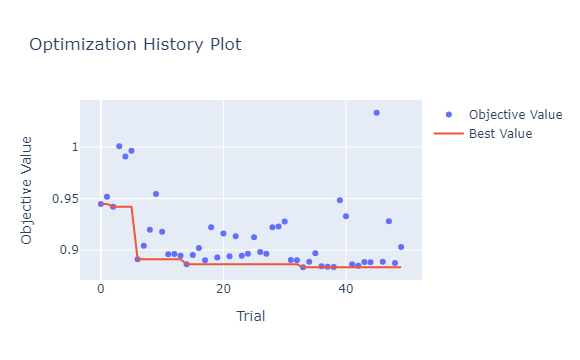

In [23]:
optuna.visualization.plot_optimization_history(study)


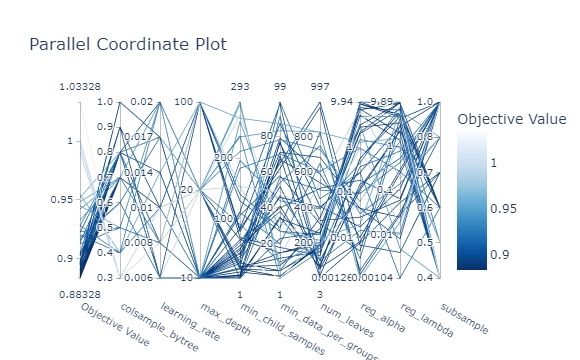

In [24]:
optuna.visualization.plot_parallel_coordinate(study)


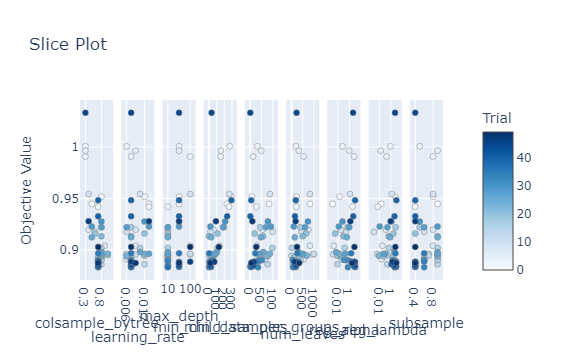

In [25]:
optuna.visualization.plot_slice(study)


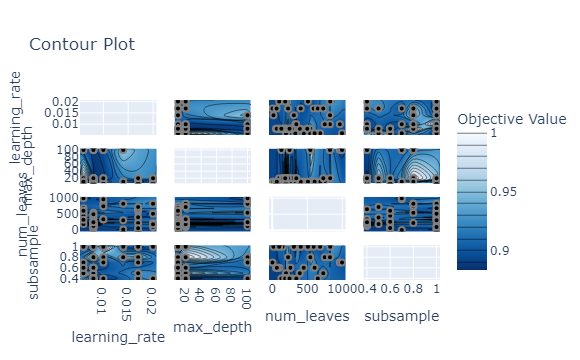

In [26]:
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

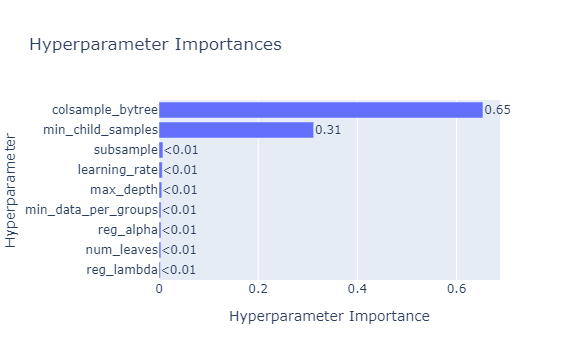

In [27]:
optuna.visualization.plot_param_importances(study)


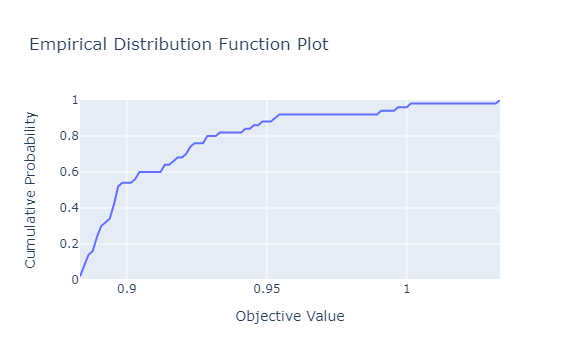

In [28]:
optuna.visualization.plot_edf(study)


In [29]:
predictand_valid_grid.shape

(1826, 10, 10, 1)

In [30]:
params

{'reg_alpha': 0.5538674094865402,
 'reg_lambda': 5.885354785470161,
 'colsample_bytree': 0.7,
 'subsample': 0.6,
 'learning_rate': 0.008,
 'max_depth': 10,
 'num_leaves': 65,
 'min_child_samples': 1,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 35}

In [31]:
#params['early_stopping'] = 100
params['verbose'] = -1

predictions = np.ones(shape=(predictand_valid_grid.shape[0], predictand_valid_grid.shape[1], predictand_valid_grid.shape[2])) * np.nan
LogConfig.init_log('predictions Shape check: {} '.format(predictions.shape))
rmse_val = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
model = LGBMRegressor(**params)

for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):

        point_predictors = predictors_train_grid[:, j, i, :]
        point_predictand = predictand_train_grid[:, j, i, :]

        # check if the grid point is valid
        if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
            # move on to next grid point
            continue

        # prepare predictors of validation period
        point_validation = predictors_valid_grid[:, j, i, :]
        #point_validation = normalize(point_validation)

        predictand_validation = predictand_valid_grid[:, j, i, :]

        LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))  
        model.fit(point_predictors,point_predictand)
        preds = model.predict(point_validation)
        rmse = mean_squared_error(predictand_validation, preds, squared=False)           
        rmse_val[i][j] = rmse
        LogConfig.init_log('Current grid point: ({:d}), ({:d}) RMSE: {}'.format(i, j, rmse_val[i][j]))
        predictions[:, j, i] = preds

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T23:34:52: predictions Shape check: (1826, 10, 10) 
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T23:34:52: Current grid point: (0), (0) 
downscaleml.core.utils: --------------------------------------------------------------------------------
/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-18T23:35:17: Current 

In [32]:
predictions.shape

(1826, 10, 10)

In [33]:
predictand_valid_grid.shape

(1826, 10, 10, 1)

predictand_valid_grid = np.squeeze(predictand_valid_grid)

r2_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mae_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mse_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))


for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):
        r2_values[i][j] = r2_score(predictand_valid_grid[:, j, i], predictions[:, j, i])
        mae_values[i][j] = mean_absolute_error(predictand_valid_grid[:, j, i], predictions[:, j, i])
        mse_values[i][j] = mean_squared_error(predictand_valid_grid[:, j, i], predictions[:, j, i])

mean_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))

for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):
        mean_values[i][j] = np.mean(predictand_valid_grid[:, j, i])
        

mean_values

In [34]:
# store predictions in xarray.Dataset
prediction = xr.DataArray(data=predictions, dims=['time', 'y', 'x'],
                        coords=dict(time=pd.date_range(Era5_valid.time.values[0],Era5_valid.time.values[-1], freq='D'),
                                    lat=reduced_grid_y, lon=reduced_grid_x))
prediction = prediction.to_dataset(name=PREDICTAND)

prediction = prediction.set_index(
    time='time',
    y='lat',
    x='lon'
)

y_pred = prediction

y_true = xr.DataArray(data=np.squeeze(predictand_valid_grid), dims=['time', 'y', 'x'],
                        coords=dict(time=pd.date_range(Era5_valid.time.values[0],Era5_valid.time.values[-1], freq='D'),
                                    lat=reduced_grid_y, lon=reduced_grid_x))
y_true = y_true.to_dataset(name=PREDICTAND)

y_true = y_true.set_index(
    time='time',
    y='lat',
    x='lon'
)



In [35]:
y_true

<xarray.Dataset>
Dimensions:  (time: 1826, y: 10, x: 10)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.7 44.76 49.39 ... 43.82 45.43 47.92 43.82
  * x        (x) float64 6.963 9.782 8.91 6.829 ... 5.621 6.628 9.044 15.42
Data variables:
    tasmean  (time, y, x) float64 275.5 284.0 285.3 275.4 ... 270.1 283.5 286.4

In [36]:
y_pred

<xarray.Dataset>
Dimensions:  (time: 1826, y: 10, x: 10)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.7 44.76 49.39 ... 43.82 45.43 47.92 43.82
  * x        (x) float64 6.963 9.782 8.91 6.829 ... 5.621 6.628 9.044 15.42
Data variables:
    tasmean  (time, y, x) float64 275.7 284.6 285.9 275.8 ... 270.0 284.2 286.3

In [37]:
y_pred = y_pred - 273.15
y_true = y_true - 273.15

In [38]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)

Starting year: 2016
Ending year: 2020


In [39]:
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [40]:
y_true

<xarray.DataArray 'tasmean' (time: 1826, y: 10, x: 10)>
array([[[ 2.32775269e+00,  1.08107239e+01,  1.21677795e+01, ...,
          2.18999634e+00,  1.20941406e+01,  8.64956055e+00],
        [-2.17636719e+00,  5.57000732e-01,  4.89007568e-01, ...,
         -2.16864014e-01,  4.88916016e-01, -2.28461304e+00],
        [-3.00543823e+00,  8.03491211e-01,  2.07875977e+00, ...,
         -1.70050659e+00,  1.13738403e+00, -2.83316650e+00],
        ...,
        [-6.21857300e+00,  1.30574951e+00,  1.66942749e+00, ...,
          9.46069336e-01,  1.93337402e+00, -2.24765625e+00],
        [ 2.74208984e+00,  3.33440552e+00,  2.10347900e+00, ...,
          4.11852417e+00,  2.30083618e+00, -6.38037109e-01],
        [ 2.32775269e+00,  1.08107239e+01,  1.21677795e+01, ...,
          2.18999634e+00,  1.20941406e+01,  8.64956055e+00]],

       [[ 3.49065552e+00,  1.22591797e+01,  1.11729980e+01, ...,
          3.05208740e+00,  1.16466309e+01,  1.09106995e+01],
        [-4.05695190e+00,  2.48712158e-01,  7.01654053e-01, ...,
         -1.14169922e+00,  7.28112793e-01, -2.02139893e+00],
        [-3.15863647e+00,  4.24462891e-01,  5.82275391e-03, ...,
         -1.29916992e+00, -7.45428467e-01, -3.34838867e-02],
...
        [-1.07190308e+01, -4.96435547e-01, -6.91900635e-01, ...,
         -3.29907837e+00, -7.62060547e-01,  7.18221436e+00],
        [ 2.18139648e-02,  5.59472656e-01,  1.66772461e-01, ...,
          7.60797119e-01,  6.33966064e-01,  1.15810547e+00],
        [-1.18164062e-02,  1.44641357e+01,  1.39265991e+01, ...,
         -8.32800293e-01,  1.41133972e+01,  1.58425232e+01]],

       [[-1.56778564e+00,  1.20116821e+01,  1.01050659e+01, ...,
         -3.06470337e+00,  1.03799072e+01,  1.32377563e+01],
        [-1.09268250e+01,  2.04424438e+00,  1.57924805e+00, ...,
         -7.79910889e+00,  1.30584106e+00,  4.22097168e+00],
        [-1.24813599e+01, -1.15454102e-01,  9.25500488e-01, ...,
         -9.63016357e+00,  2.79290771e-01,  2.89806519e+00],
        ...,
        [-1.50747437e+01,  1.45025024e+00, -2.61175537e-01, ...,
         -5.31204834e+00, -1.19787598e-01,  5.14159546e+00],
        [-4.68756104e-01, -3.21936035e-01, -1.38550415e+00, ...,
          1.94635010e-01, -1.68796387e+00, -5.98669434e-01],
        [-1.56778564e+00,  1.20116821e+01,  1.01050659e+01, ...,
         -3.06470337e+00,  1.03799072e+01,  1.32377563e+01]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.7 44.76 49.39 ... 43.82 45.43 47.92 43.82
  * x        (x) float64 6.963 9.782 8.91 6.829 ... 5.621 6.628 9.044 15.42

In [41]:
y_pred

<xarray.DataArray 'tasmean' (time: 1826, y: 10, x: 10)>
array([[[  2.55454426,  11.48172731,  12.7371293 , ...,   2.69966392,
          13.05188303,   8.66367259],
        [ -2.84080573,   1.42083256,   1.55878799, ...,   1.21867256,
           1.34285894,  -2.6146729 ],
        [ -2.65108317,   0.66376527,   1.26850844, ...,  -1.75509839,
           1.1212502 ,  -1.07243108],
        ...,
        [ -6.1693686 ,   0.90896225,   1.62778117, ...,   1.146449  ,
           1.79756399,  -2.92141999],
        [  2.46590201,   2.73655702,   2.13385694, ...,   4.04327678,
           2.22201321,  -0.79286566],
        [  2.55454426,  11.48172731,  12.7371293 , ...,   2.69966392,
          13.05188303,   8.66367259]],

       [[  4.38160645,  12.24882003,  10.87749165, ...,   3.00263738,
          11.50631737,  10.12639453],
        [ -3.84857887,   1.20443062,   0.55538823, ...,  -1.19258699,
           0.73320724,  -2.34419632],
        [ -3.98026823,  -0.20504668,  -0.45721969, ...,  -1.48860807,
          -1.02895017,  -0.86389194],
...
        [-13.65507596,  -0.05549794,  -0.18706361, ...,  -4.47011157,
          -0.4817538 ,   6.22440282],
        [  1.01096378,   0.65268954,  -0.17788316, ...,   1.58586089,
           0.3094495 ,   1.11265223],
        [  0.05857913,  12.62462822,  12.61076862, ...,  -1.22621602,
          12.70184583,  15.42315104]],

       [[ -1.87121517,  10.98991604,  10.84227288, ...,  -3.16102601,
          11.01009471,  13.12677297],
        [-11.57705028,   0.92800858,   0.08453976, ...,  -7.97679899,
           0.04193322,   5.31667005],
        [-10.7362226 ,   0.70448427,  -1.33732464, ..., -10.18114489,
          -0.96409325,   3.43355477],
        ...,
        [-15.92335001,   0.08652898,  -0.62842924, ...,  -7.12848559,
          -0.47571748,   6.04478446],
        [ -0.71470584,   1.10399648,  -0.61966916, ...,   0.46862761,
          -0.11663288,   0.31348108],
        [ -1.87121517,  10.98991604,  10.84227288, ...,  -3.16102601,
          11.01009471,  13.12677297]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.7 44.76 49.39 ... 43.82 45.43 47.92 43.82
  * x        (x) float64 6.963 9.782 8.91 6.829 ... 5.621 6.628 9.044 15.42

In [42]:
### calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [43]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [44]:
import warnings

# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [45]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 1.00
R2 on daily anomalies: 0.92


### Coefficient of determination: Spatially

In [46]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred.x), len(y_pred.y)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, i, j] = r2_score(point_true, point_pred)
        r2[1, i, j] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_173669/1191949613.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/tmp/ipykernel_173669/1191949613.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



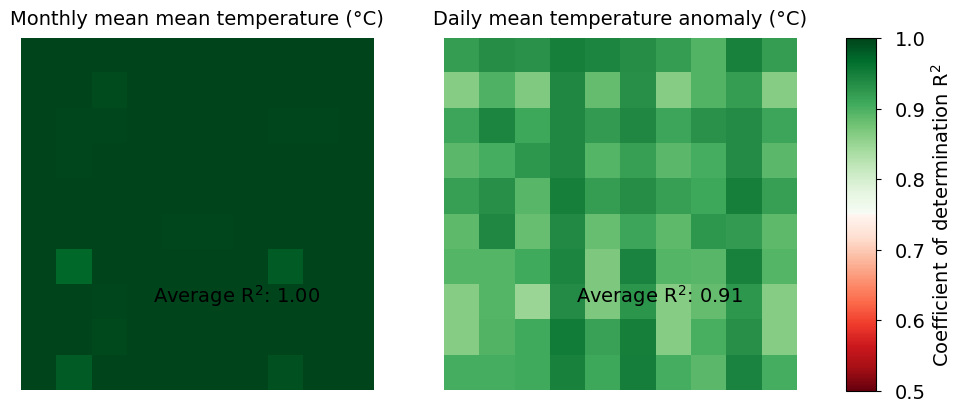

In [47]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'LGBM $T_{\mathrm{mean \ daily}}$'
TRUE = 'Target $T_{\mathrm{mean \ daily}}$'

from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0.5, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
#fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [48]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average bias of tasmean: -0.11°C


In [49]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average MAE of tasmean: 0.16°C


In [50]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average RMSE of tasmean: 0.23°C


In [51]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2016): 1.00
(2017): 1.00
(2018): 1.00
(2019): 1.00
(2020): 1.00
Yearly average Pearson correlation coefficient for tasmean: 1.00


Text(8, 12, 'RMSE = 0.23°C')

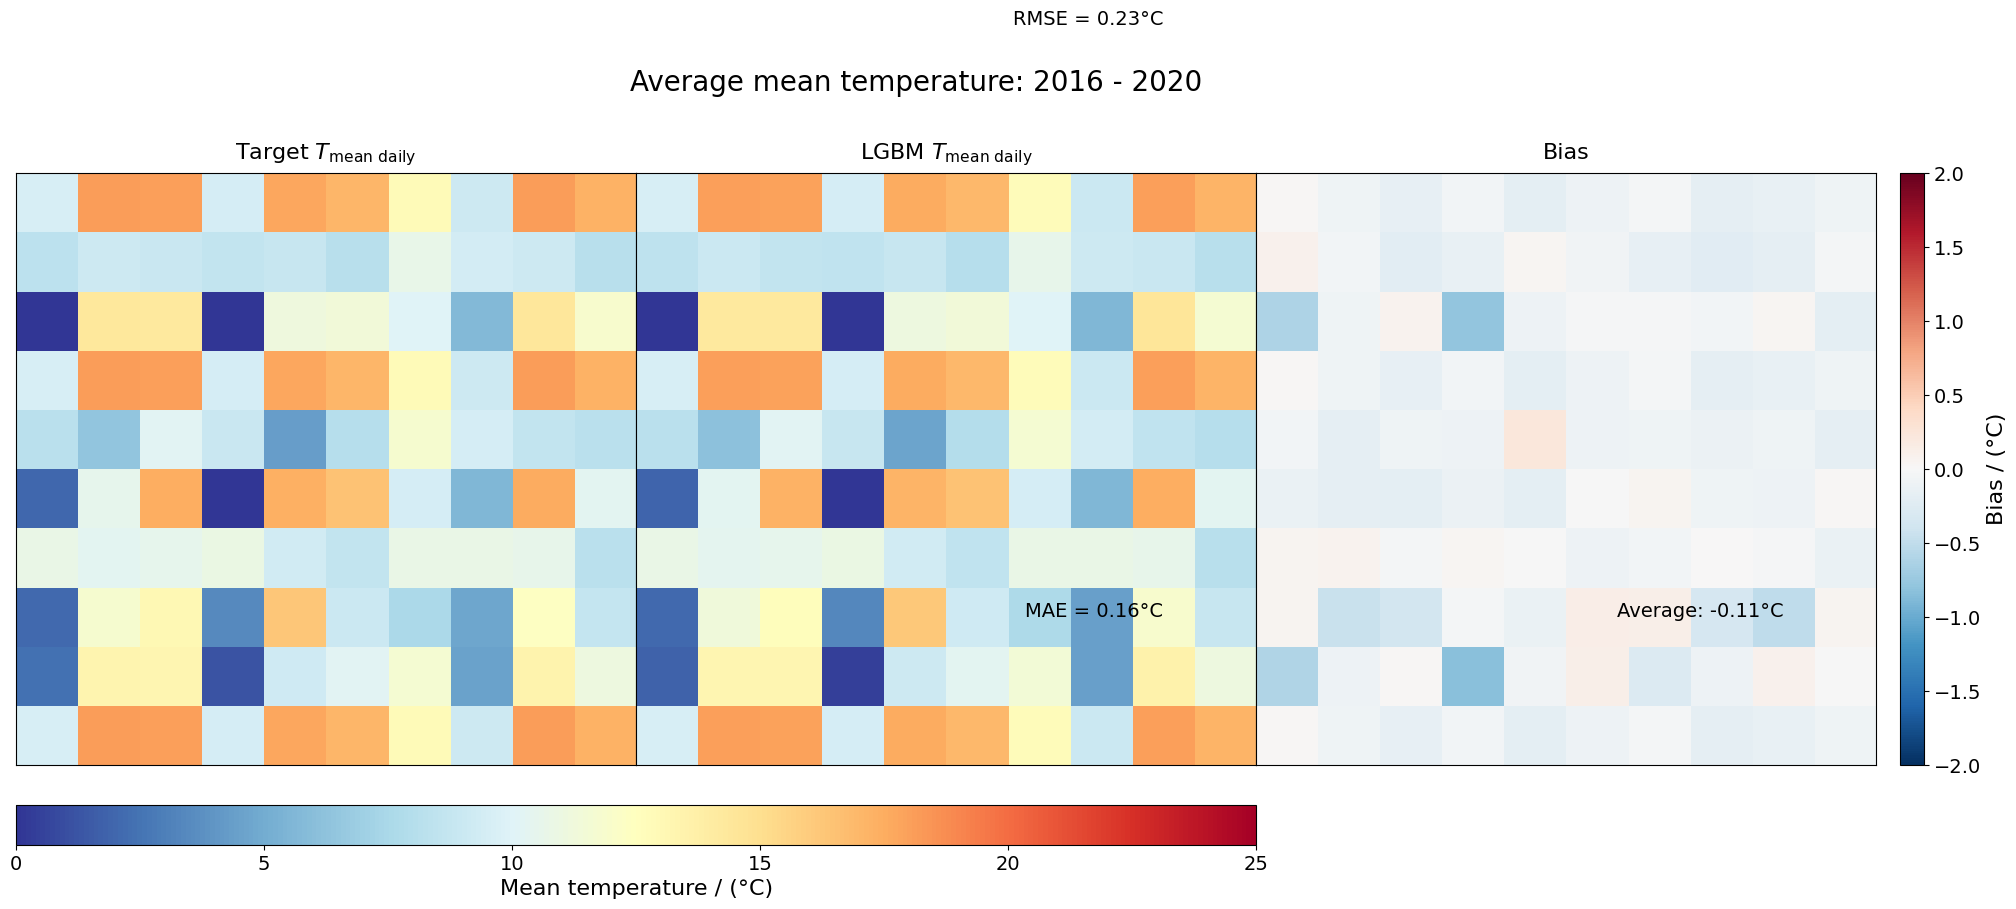

In [52]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [53]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [54]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season DJF: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season JJA: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season MAM: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season SON: -0.1°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

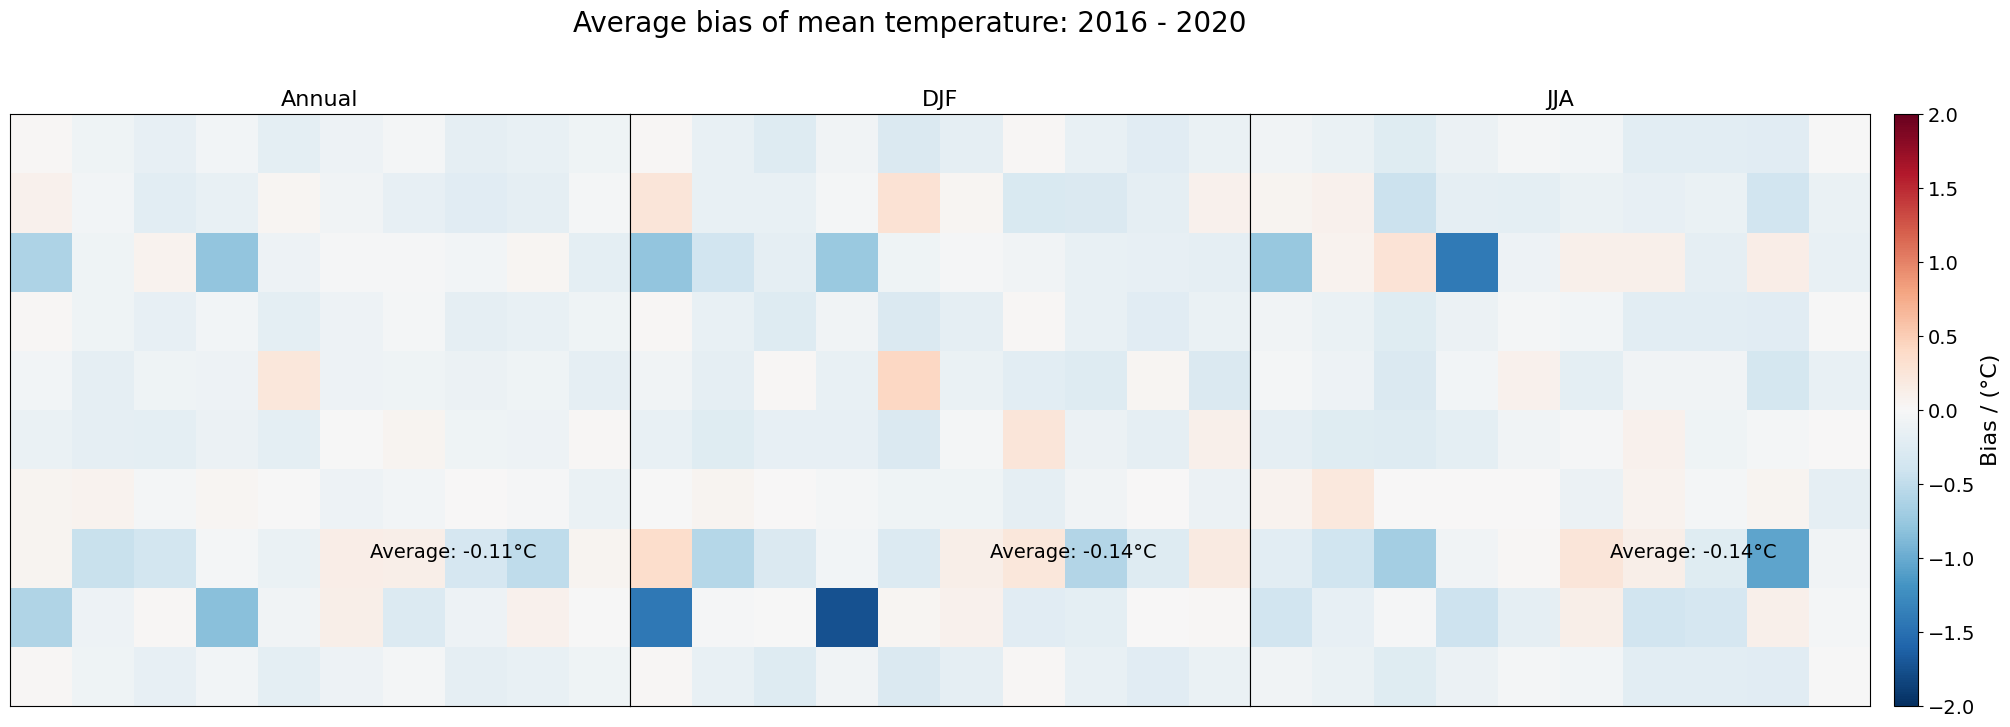

In [55]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [56]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [57]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [58]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [59]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average bias for P98 of tasmean: -0.3°C


In [60]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [61]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average MAE for P98 of tasmean: 0.4°C


In [62]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [63]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98 of tasmean: 0.6°C


Text(8, 12, 'RMSE = 0.60°C$^2$')

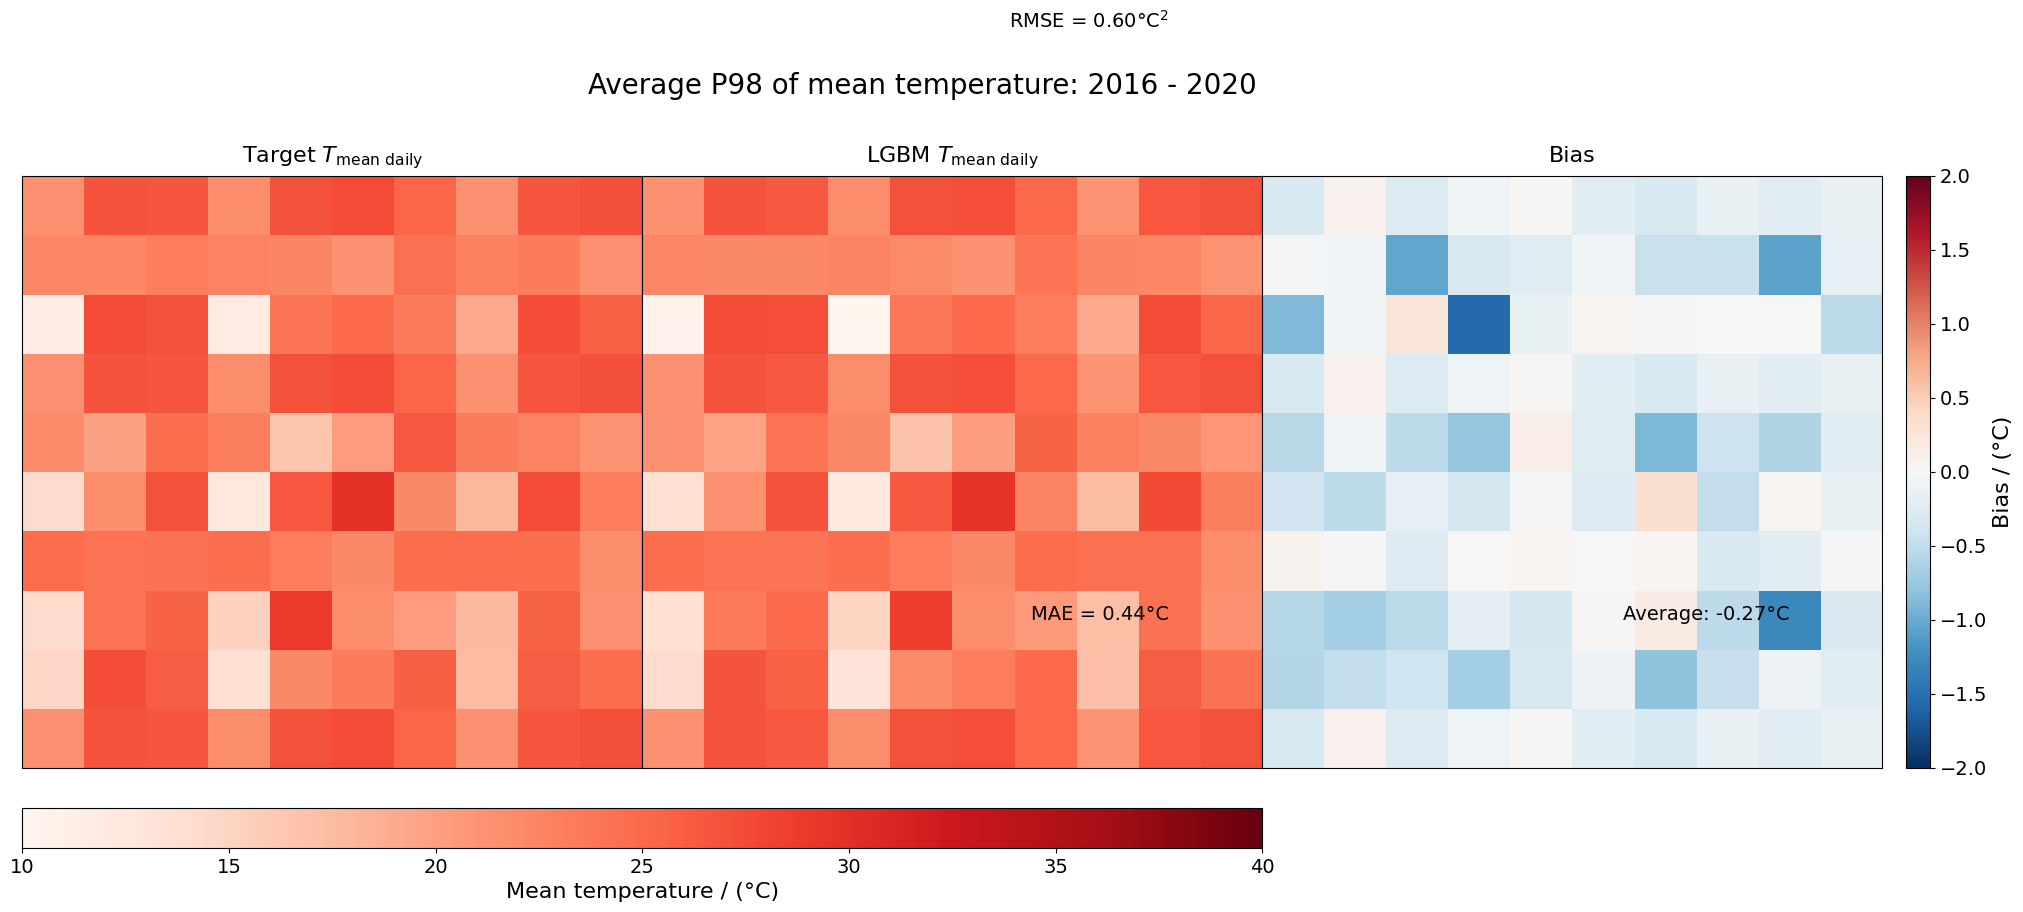

In [64]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

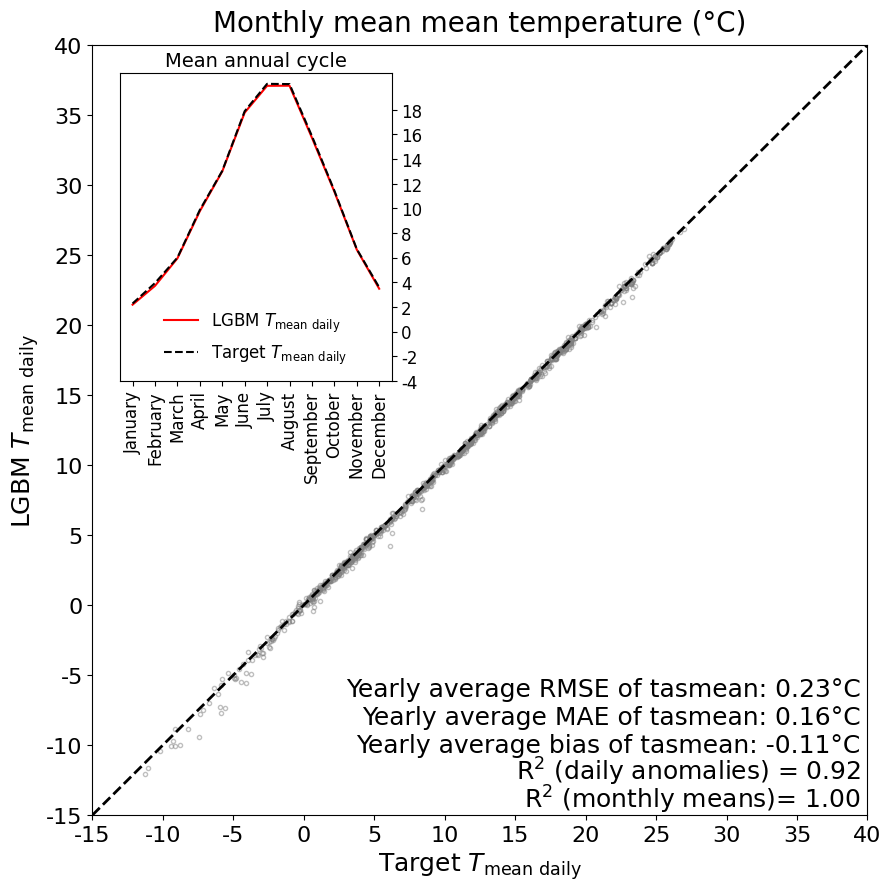

In [65]:

import calendar
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('Target $T_{\mathrm{mean \ daily}}$', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='Target $T_{\mathrm{mean \ daily}}$')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

#plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
